<a href="https://colab.research.google.com/github/Catairu/AIML_project/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎧 Spotify Million Playlist Dataset Challenge

The **Spotify Million Playlist Dataset (MPD)** is a large-scale dataset created to support research in music recommendation systems. It was introduced as part of the **RecSys Challenge 2018**, which took place from January to July 2018.

This dataset contains **1,000,000 user-generated playlists**, collected from the Spotify platform between **January 2010 and October 2017**. Each playlist includes metadata such as:
- Playlist titles
- Track titles
- Track URIs and other contextual information

---
The main task is to develop systems for **automatic playlist continuation**  




# 📥 Importing Required Libraries



In [ ]:
import os
import json
import torch
from zipfile import ZipFile

import gc

from tqdm import tqdm

import gdown

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter, defaultdict
import heapq
import itertools

from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD


# 📦 Dataset Download


In [ ]:
FOLDER_PATH: str = "/content/Data/MPD.zip"
FOLDER_ID: str = "1iPEPBSF9Ce-6rHWRwqZtAZy9ebeVkn_Z"


if not (os.path.exists(FOLDER_PATH) | os.path.exists("/content/data")):
   gdown.download_folder(f"https://drive.google.com/drive/folders/{FOLDER_ID}",
                         output="Dataset", quiet=False)
if not os.path.exists("/content/data"):
  with ZipFile(FOLDER_PATH, 'r') as zip:
      files_to_extract: list[str] = [f for f in zip.namelist() if f.startswith("data/")]
      for file in tqdm(files_to_extract, desc='Extracting files'):
          zip.extract(member=file, path="/content/")

!rm -rf /content/Dataset

Retrieving folder contents


Processing file 18x15EyV3nvoR04Uku5wbEIDsfO2A9KUi MPD.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed


FileURLRetrievalError: Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=18x15EyV3nvoR04Uku5wbEIDsfO2A9KUi

but Gdown can't. Please check connections and permissions.

# 📊 EDA
Each file in the dataset contains 1,000 playlists, with an average of 66.35 tracks per playlist. For every track, we also have detailed metadata, which includes:

    Artist: The performer or group associated with the track.

    Album: The album or collection the track belongs to.

    Track Name: The title of the track.

    Track Duration: The length of the track in seconds or minutes.

Using this rich set of data, we can analyze the most popular artists and tracks within the dataset.


In [ ]:
with open("/content/data/mpd.slice.0-999.json", 'r') as f:
    single_file = json.load(f)

single_file['playlists'][0]['tracks'][0]

In [ ]:
all_artists = [track["artist_name"] for p in single_file["playlists"] for track in p["tracks"]]
artist_counts = Counter(all_artists)
all_tracks = [track["track_name"] for p in single_file["playlists"] for track in p["tracks"]]
track_counts = Counter(all_tracks)

top_tracks = pd.DataFrame(track_counts.most_common(10), columns=["Track", "Count"])
top_artists = pd.DataFrame(artist_counts.most_common(10), columns=["Artist", "Count"])
pd.concat([top_tracks, top_artists], axis=1)

In [ ]:
num_tracks = np.array([p["num_tracks"] for p in single_file["playlists"]])
min_tracks = np.min(num_tracks)
max_tracks = np.max(num_tracks)
avg_tracks = np.mean(num_tracks)

plt.figure(figsize=(10, 5))
plt.hist(num_tracks, bins=50, color="skyblue", edgecolor="black", alpha=0.7)

plt.axvline(x=10, color="red", linestyle="dashed", label="Min threshold (10)")
plt.axvline(x=150, color="green", linestyle="dashed", label="Max threshold (150)")

plt.xlabel("Number of Tracks per Playlist")
plt.ylabel("Count")
plt.title("Distribution of Playlist Lengths in MPD")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

print(f"Min number of tracks: {min_tracks}")
print(f"Max number of tracks: {max_tracks}")
print(f"Average number of tracks: {avg_tracks:.2f}")

In [ ]:
df_playlists = pd.DataFrame(single_file["playlists"])
df_playlists.sort_values(by="num_followers", ascending=False).head()

# Similarity Check
I used Jaccard similarity to measure how similar two playlists are, with the goal of identifying and potentially removing playlists that are too similar to each other. Highly similar playlists may contain redundant information, which could be unnecessary or even harmful during the training phase.

Jaccard similarity is defined as the size of the intersection divided by the size of the union of two sets—in this case, the sets of tracks in each playlist.
$$
\text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

In [ ]:
def jaccard_similarity(set1, set2):
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

playlist_sets = {p["pid"]: {t["track_uri"] for t in p["tracks"]} for p in single_file["playlists"]}

pids = list(playlist_sets.keys())
n = len(pids)
similarity_matrix = np.zeros((n, n))
top_similarities = []

for i in range(n):
    for j in range(i+1, n):
        sim = jaccard_similarity(playlist_sets[pids[i]], playlist_sets[pids[j]])
        similarity_matrix[i, j] = sim
        similarity_matrix[j, i] = sim

        if len(top_similarities) < 10:
            heapq.heappush(top_similarities, (sim, pids[i], pids[j]))
        else:
            heapq.heappushpop(top_similarities, (sim, pids[i], pids[j]))

top_similarities = sorted(top_similarities, reverse=True)

print("\nTop 10 most similar playlist pairs (Jaccard):")
for rank, (sim, pid1, pid2) in enumerate(top_similarities, 1):
    print(f"{rank}. Playlist {pid1} & {pid2} → Similarity: {sim:.4f}")

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap="coolwarm", cbar=True)
plt.title("Heatmap della Similarità di Jaccard tra Playlist")
plt.xlabel("ID Playlist")
plt.ylabel("ID Playlist")
plt.show()


In [ ]:
del single_file, all_artists, artist_counts, all_tracks, track_counts, top_tracks, top_artists, num_tracks, min_tracks, max_tracks, avg_tracks, df_playlists, playlist_sets, similarity_matrix, top_similarities
gc.collect()

#🔍 Data Preprocessing and Train-Test Split

In [ ]:
def process_track(track, playlist_id):
    if track['track_uri'] not in track_ids:
        track_id = len(track_ids)
        track_ids[track['track_uri']] = track_id
        tracks_metadata.append((track_id, track['track_name'], track['artist_name']))
    return (playlist_id, track_ids[track['track_uri']], 1)

train_data = []
test_data = []
track_ids = dict()
playlists_metadata = []
tracks_metadata = []
files_to_extract = sorted([f"/content/data/{f}" for f in os.listdir("/content/data")], key=lambda x : int(x.split('.')[2].split('-')[0]))
for file in tqdm(files_to_extract, desc="Processing files"):
    with open(file, 'r') as f:
        data = json.load(f)
    for playlist in data['playlists']:
      playlist_id = playlist['pid']
      playlists_metadata.append(( playlist_id, playlist['num_tracks'], playlist['num_followers']))
      tracks_data = [process_track(track, playlist_id) for track in  playlist['tracks']]
      np.random.shuffle(tracks_data)
      splitting_point = int(playlist['num_tracks']*0.8)
      train_data.extend(tracks_data[:splitting_point])
      test_data.extend(tracks_data[splitting_point:])


train_df = pd.DataFrame(train_data, columns=['playlist_id', 'track_id', 'presence']).astype({'playlist_id': 'uint32', 'track_id': 'uint32', 'presence': 'uint8'})
test_df = pd.DataFrame(test_data, columns=['playlist_id', 'track_id', 'presence']).astype({'playlist_id': 'uint32', 'track_id': 'uint32', 'presence': 'uint8'})
playlists_metadata_df = pd.DataFrame(playlists_metadata, columns=['playlist_id', 'num_tracks', 'num_followers']).astype({'playlist_id': 'uint32', 'num_tracks': 'uint16', 'num_followers': 'uint32'})
tracks_metadata_df = pd.DataFrame(tracks_metadata, columns=['track_id', 'track_name', 'artist_name']).astype({'track_id': 'uint32', 'track_name': 'category', 'artist_name': 'category'})


In [ ]:
keep_vars = {
    'train_df', 'test_df', 'playlists_metadata_df', 'tracks_metadata_df',
    'pd', 'np', 'os', 'json', 'tqdm', 'gc',
    'plt', 'sns',
    'Counter', 'defaultdict',
    'heapq', 'itertools',
    'csr_matrix', 'TruncatedSVD'
}

for var in list(globals().keys()):
    if var not in keep_vars and not var.startswith("_"):
        del globals()[var]

gc.collect()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_df = pd.read_parquet("/content/drive/MyDrive/playlist_project/train_df.parquet")
test_df = pd.read_parquet("/content/drive/MyDrive/playlist_project/test_df.parquet")
playlists_metadata_df = pd.read_parquet("/content/drive/MyDrive/playlist_project/playlists_metadata_df.parquet")
tracks_metadata_df = pd.read_parquet("/content/drive/MyDrive/playlist_project/tracks_metadata_df.parquet")

In [ ]:
train_df.memory_usage(deep=True)

,0
Index,132
playlist_id,210717988
track_id,210717988
presence,52679497


In [ ]:
test_df.memory_usage(deep=True)

,0
Index,132
playlist_id,54667724
track_id,54667724
presence,13666931


In [ ]:
playlists_metadata_df.memory_usage(deep=True)

,0
Index,132
playlist_id,4000000
num_tracks,2000000
num_followers,4000000


In [ ]:
tracks_metadata_df.memory_usage(deep=True)

,0
Index,132
track_id,9049168
track_name,165893619
artist_name,38077269


# 📊 EDA




In [ ]:
track_name_map = tracks_metadata_df.set_index('track_id')['track_name'].to_dict()
artist_name_map = tracks_metadata_df.set_index('track_id')['artist_name'].to_dict()

all_track_ids = train_df['track_id']

all_tracks = all_track_ids.map(track_name_map).tolist()
all_artists = all_track_ids.map(artist_name_map).tolist()

artist_counts = Counter(all_artists)
track_counts = Counter(all_tracks)

top_tracks = pd.DataFrame(track_counts.items(), columns=["Track", "Track Count"])
top_artists = pd.DataFrame(artist_counts.items(), columns=["Artist", "Artist Count"])
top_tracks = top_tracks.sort_values(by="Track Count", ascending=False)
top_artists = top_artists.sort_values(by="Artist Count", ascending=False)
top_tracks_10 = top_tracks.head(10).reset_index(drop=True)
top_artists_10 = top_artists.head(10).reset_index(drop=True)

top_combined = pd.concat([top_tracks_10, top_artists_10], axis=1)
top_combined


,Track,Track Count,Artist,Artist Count
0,Closer,54190,Drake,672499
1,Home,40213,Kanye West,328153
2,HUMBLE.,37028,Kendrick Lamar,280719
3,One Dance,35063,Rihanna,269632
4,Roses,34894,The Weeknd,251493
5,Congratulations,33445,Eminem,234295
6,Broccoli (feat. Lil Yachty),32698,Ed Sheeran,215860
7,Let Me Love You,31791,Future,199452
8,Ride,31480,Justin Bieber,193128
9,Forever,29975,J. Cole,192075


In [ ]:
track_pop_scores = {}
artist_pop_scores = {}

max_track_count = max(track_counts.values())
max_artist_count = max(artist_counts.values())

for track_id in track_name_map:
    track_name = track_name_map[track_id]
    artist_name = artist_name_map[track_id]

    track_count = track_counts.get(track_name, 0)
    artist_count = artist_counts.get(artist_name, 0)

    track_pop_scores[track_id] = track_count / max_track_count
    artist_pop_scores[track_id] = artist_count / max_artist_count

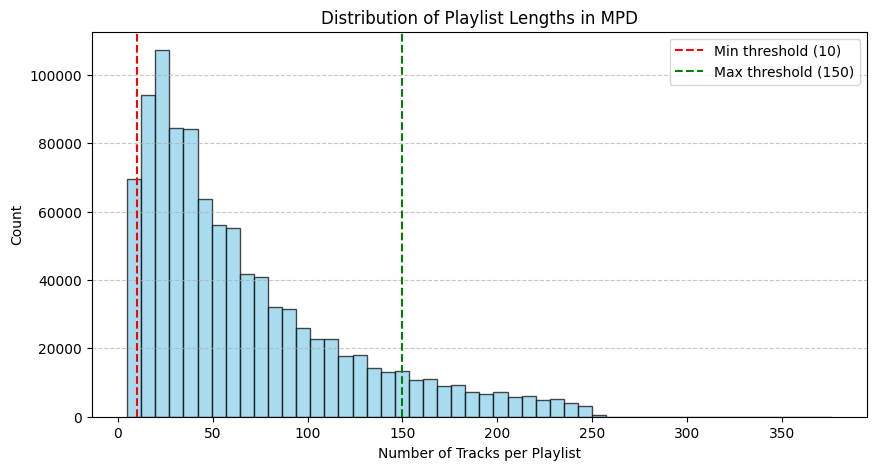

Min number of tracks: 5
Max number of tracks: 376
Average number of tracks: 66.35


In [ ]:
num_tracks = np.array(playlists_metadata_df['num_tracks'])
min_tracks = np.min(num_tracks)
max_tracks = np.max(num_tracks)
avg_tracks = np.mean(num_tracks)
plt.figure(figsize=(10, 5))
plt.hist(num_tracks, bins=50, color="skyblue", edgecolor="black", alpha=0.7)

plt.axvline(x=10, color="red", linestyle="dashed", label="Min threshold (10)")
plt.axvline(x=150, color="green", linestyle="dashed", label="Max threshold (150)")

plt.xlabel("Number of Tracks per Playlist")
plt.ylabel("Count")
plt.title("Distribution of Playlist Lengths in MPD")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

print(f"Min number of tracks: {min_tracks}")
print(f"Max number of tracks: {max_tracks}")
print(f"Average number of tracks: {avg_tracks:.2f}")

In [ ]:
num_total = len(playlists_metadata_df)
num_in_range = ((playlists_metadata_df['num_tracks'] >= 10) & (playlists_metadata_df['num_tracks'] <= 150)).sum()
percentage = (num_in_range / num_total) * 100

print(f"{percentage:.2f}% of playlists have between 6 and 200 tracks.")


86.85% of playlists have between 6 and 200 tracks.


In [ ]:
playlists_metadata_df.sort_values(by="num_followers", ascending=False).head()

,playlist_id,num_tracks,num_followers
248269,248269,39,71643
746359,746359,106,53519
399472,399472,111,45942
180831,180831,85,31539
720740,720740,81,27830


In [ ]:
from scipy.special import expit

log_weights = np.log2(playlists_metadata_df["num_followers"]+1)
playlists_metadata_df["weight"] = expit(log_weights)


In [ ]:
playlist_weights_dict = dict(zip(playlists_metadata_df["playlist_id"], playlists_metadata_df["weight"]))

In [ ]:
playlists_metadata_df.sort_values(by="weight", ascending=True)

,playlist_id,num_tracks,num_followers,weight
619898,619898,79,1,0.731059
619882,619882,51,1,0.731059
619883,619883,46,1,0.731059
619884,619884,171,1,0.731059
619886,619886,232,1,0.731059
...,...,...,...,...
720740,720740,81,27830,1.000000
180831,180831,85,31539,1.000000
399472,399472,111,45942,1.000000
746359,746359,106,53519,1.000000


# 🛠️ Model Training

In [ ]:
num_tracks = pd.concat([train_df['track_id'], test_df['track_id']]).nunique()
num_playlists = train_df["playlist_id"].max() +1
train_sparse_weighted = csr_matrix(
    (train_df["presence"].astype(np.float32), (train_df["playlist_id"], train_df["track_id"])),
    shape=(num_playlists, num_tracks)
)



In [ ]:
track_pop_vec = torch.zeros(num_tracks, dtype=torch.float32)
for track_id, score in track_pop_scores.items():
        track_pop_vec[track_id] = score
artist_pop_vec = torch.zeros(num_tracks, dtype=torch.float32)
for track_id, score in artist_pop_scores.items():
        artist_pop_vec[track_id] = score
playlist_weights_vec = torch.zeros(num_playlists, dtype=torch.float32)
for playlist_id, score in playlist_weights_dict.items():
    playlist_weights_vec[playlist_id] = score



In [ ]:
track_pop_vec = track_pop_vec.cuda()
artist_pop_vec = artist_pop_vec.cuda()
playlist_weights_vec = playlist_weights_vec.cuda()

In [ ]:
svd = TruncatedSVD(n_components=200)
train_svd = svd.fit_transform(train_sparse_weighted).astype(np.float32)
V_gpu = torch.tensor(svd.components_.T , dtype=torch.float32).cuda()


In [ ]:
del train_sparse_weighted, svd, num_tracks, num_playlists, playlists_metadata_df, tracks_metadata_df, track_name_map, artist_name_map, all_track_ids, all_tracks, all_artists, artist_counts, track_counts, top_tracks, top_artists, top_tracks_10, top_artists_10, top_combined, track_pop_scores, artist_pop_scores, playlist_weights_dict
gc.collect()

6263

In [ ]:
train_grouped = train_df.groupby('playlist_id')['track_id'].apply(lambda x: np.array(x, dtype=np.uint32))
test_grouped = test_df.groupby('playlist_id')['track_id'].apply(lambda x: np.array(x, dtype=np.uint32))



In [ ]:
track_counts = train_df['track_id'].value_counts()
top_tracks = set(track_counts.index)

In [ ]:
del train_df, test_df,track_counts
gc.collect()

0

In [ ]:
Ks = [1, 5, 10, 15, 20]

num_eval = 10000
n = 1000000
np.random.seed(42)
test_pids = np.random.choice(np.arange(n), size=num_eval, replace=False)
results = []

for K in Ks:
    i = 0
    precision_scores = np.zeros(num_eval, dtype=np.float32)
    recall_scores = np.zeros(num_eval, dtype=np.float32)
    rr_scores = np.zeros(num_eval, dtype=np.float32)

    for pid in tqdm(test_pids, desc='Playlist done:'):
        ground_truth = test_grouped.get(pid)
        already_seen = train_grouped.get(pid)
        G = len(ground_truth)
        current_K = min(K, G)

        p_vec = torch.tensor(train_svd[pid], dtype=torch.float32).cuda()
        svd_scores = torch.matmul(V_gpu, p_vec)
        playlist_weight = playlist_weights_vec[pid]
        final_scores = (
        0.8 * svd_scores +
        0.075 * track_pop_vec +
        0.075 * artist_pop_vec +
        0.05 * playlist_weight

)
        seen_idx = torch.tensor(list(already_seen), dtype=torch.long, device=final_scores.device)
        final_scores[seen_idx] = -float('inf')

        top_scores, top_indices = torch.topk(final_scores, current_K)
        recommended = top_indices[:current_K].cpu().numpy()
        recommended_set = set(recommended)

        hits = [tid for tid in recommended if tid in ground_truth]
        H = len(hits)

        precision = H / current_K
        recall = H / G

        rr = 0.0
        for idx, tid in enumerate(recommended, 1):
            if tid in ground_truth:
                rr = 1.0 / idx
                break

        precision_scores[i] = precision
        recall_scores[i] = recall
        rr_scores[i] = rr
        i += 1

    results.append({
        "K": K,
        "Precision@K": np.mean(precision_scores),
        "Recall@K": np.mean(recall_scores),
        "MRR@K": np.mean(rr_scores)
    })

results_df = pd.DataFrame(results).set_index("K")
print(results_df)



Playlist done:: 100%|██████████| 10000/10000 [01:30<00:00, 110.11it/s]

    Precision@K  Recall@K     MRR@K
K                                  
1      0.034000  0.003636  0.034000
5      0.041152  0.019125  0.078057
10     0.045116  0.031804  0.093567
15     0.046018  0.038093  0.098093
20     0.046871  0.042042  0.099730


In [ ]:
Ks = [1, 5, 10, 15, 20]
results = []
i = 0
for K in Ks:
    precision_scores = np.zeros(1000000, dtype=np.float32)
    recall_scores = np.zeros(1000000, dtype=np.float32)
    rr_scores = np.zeros(1000000, dtype=np.float32)

    for pid in tqdm(test_grouped.index, desc='Playlist done:'):
        ground_truth = set(test_grouped.get(pid))
        already_seen = set(train_grouped.get(pid))
        G = len(ground_truth)
        current_K = min(K, G)

        unseen_top_tracks = top_tracks - already_seen
        recommended = list(itertools.islice(unseen_top_tracks, K))
        recommended_set = set(recommended)

        hits = ground_truth & recommended_set
        H = len(hits)
        precision = H / K
        recall = H / G

        rr = 0.0
        for idx, tid in enumerate(recommended, 1):
            if tid in ground_truth:
                rr = 1.0 / idx
                break

        precision_scores[i] = precision
        recall_scores[i] = recall
        rr_scores[i] = rr
        i += 1

    results.append({
        "K": K,
        "Precision@K": np.mean(precision_scores),
        "Recall@K": np.mean(recall_scores),
        "MRR@K": np.mean(rr_scores)
    })
    i = 0

results_df = pd.DataFrame(results).set_index("K")
results_df

Playlist done::   0%|          | 153/1000000 [00:17<31:34:41,  8.80it/s]


KeyboardInterrupt: 